In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.models as models

In [ ]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# 加载MNIST数据集
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# 1. MLP模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# 2. ResNet模型（修改输入层）
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
# 3. RNN模型
class RNN(nn.Module):
    def __init__(self, input_size=28, hidden_size=128, num_layers=2, num_classes=10):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28, 28)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# 4. Multi-Head Attention模型
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.embedding_dim = 28
        self.seq_length = 28
        self.attention = nn.MultiheadAttention(embed_dim=self.embedding_dim, num_heads=4, batch_first=True)
        #self.fc = nn.Linear(self.embedding_dim, 10)
        #增加全连接层和非线性激活
        self.fc = nn.Sequential(
            nn.Linear(self.embedding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        # 输入形状: (batch_size, 1, 28, 28)
        x = x.squeeze(1)  # 去掉通道维度，形状变为 (batch_size, 28, 28)
        # MultiheadAttention 需要 (batch_size, seq_length, embed_dim)
        attn_output, _ = self.attention(x, x, x)  # 自注意力
        # 输出形状: (batch_size, seq_length, embed_dim)
        # 使用最后一个时间步的输出
        x = self.fc(attn_output[:, -1, :])  # 形状: (batch_size, 10)
        return x

In [ ]:
# 训练
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

In [ ]:
#验证
def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

In [ ]:
# 绘制并保存图像函数
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, filename_prefix):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # 绘制损失图
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制准确率图
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 保存图像
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_metrics.png')
    plt.close()

In [ ]:
# 选择模型并训练
def train_and_test(model, train_loader, test_loader, filename_prefix):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(1, 11):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
        test_loss, test_accuracy = test(model, test_loader, criterion)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch}/10, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, filename_prefix)

In [ ]:
# 初始化并选择模型（可替换为其他模型）
model = RNN().to(device)
# 训练并保存图像
train_and_test(model, train_loader, test_loader, filename_prefix='rnn')
# 保存最终训练好的模型
torch.save(model.state_dict(), f'model_pth/rnn.pth')

MLP
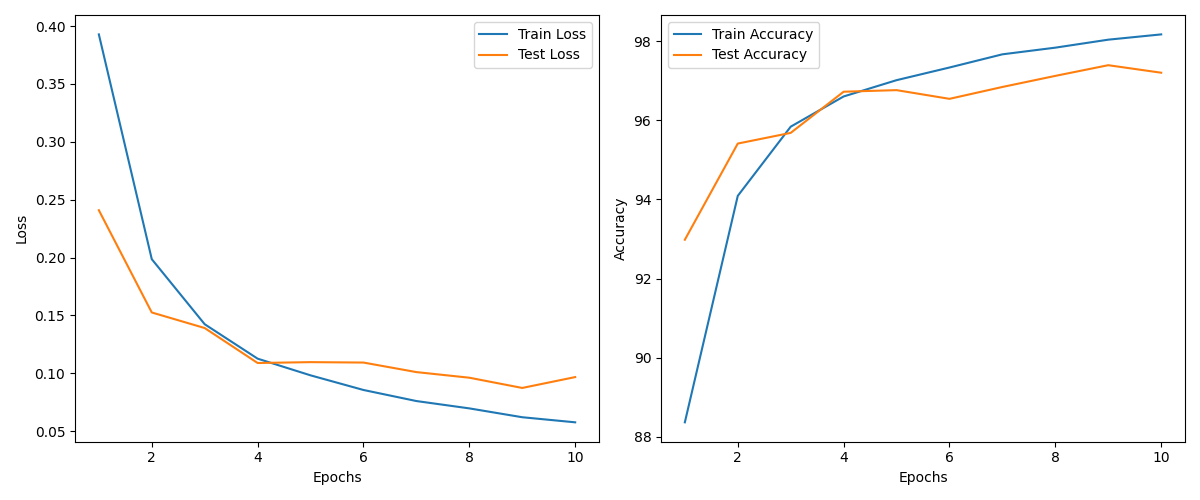
ResNet
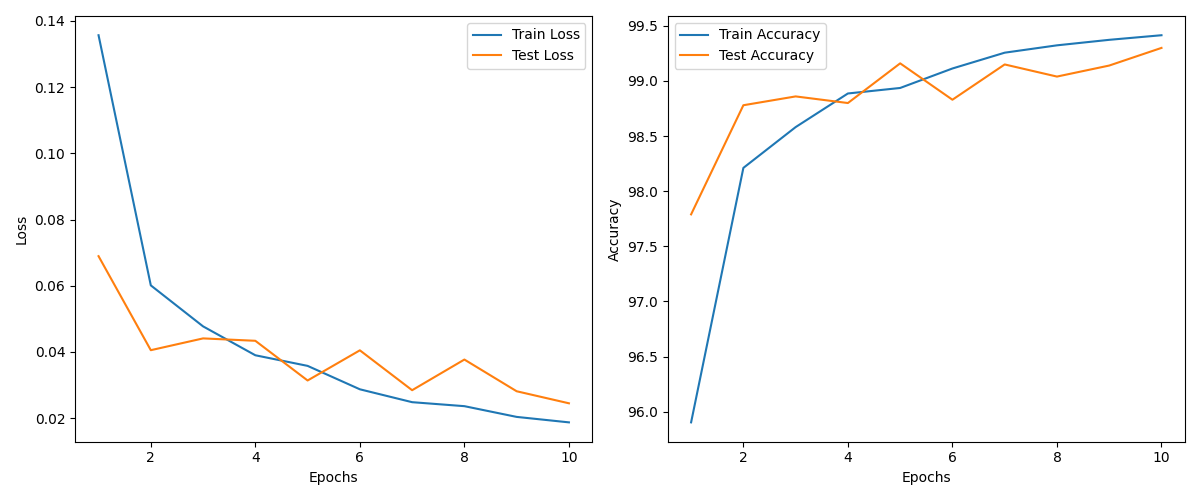
RNN
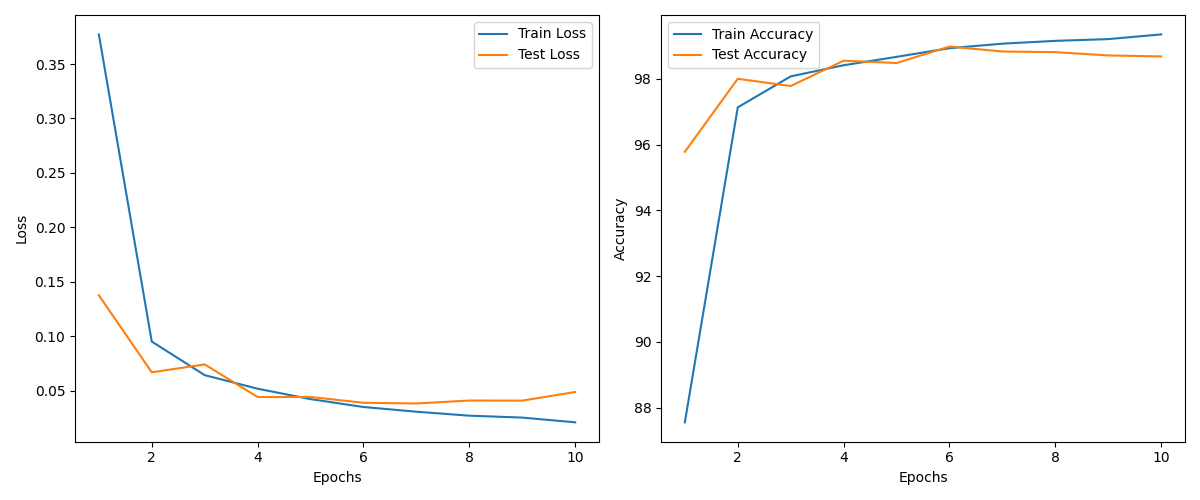
Attention
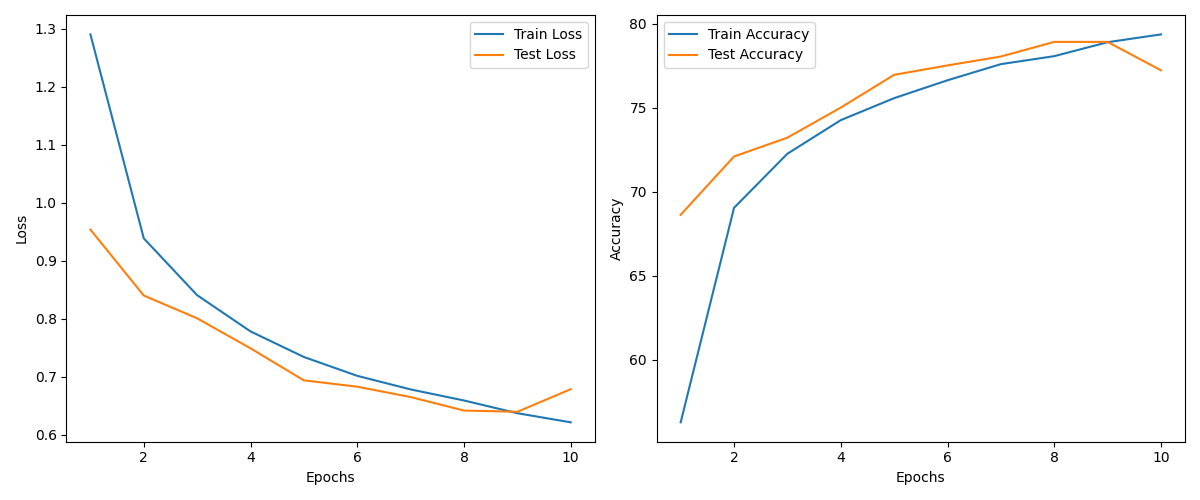